In [1]:
import csv
from collections import defaultdict
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_day_number(timestamp):
    # Define the format of the timestamp
    timestamp_format = "%d-%m-%Y %H:%M"

    # Convert the timestamp string to a datetime object
    try:
        dt_object = datetime.strptime(timestamp, timestamp_format)
    except ValueError:
        # Handle the case where the timestamp is not in the expected format
        return None

    # Define the starting reference date
    reference_date = datetime(2013, 12, 1, 0, 0)

    # Calculate the difference in days
    day_difference = (dt_object - reference_date).days
    day_difference=day_difference/24
    return day_difference + 1  # Increment by 1 to start from 1 on December 1, 2013

In [3]:
def calculate_pi(in_degree, t0, ti, t,total_degree):
    alpha = 0.02
    beta = 0.7
    return (in_degree + alpha) / (total_degree + alpha) * (t0 / (ti + t))**beta

In [4]:
incoming_edges = defaultdict(set)

In [5]:
first_appearance={}

In [6]:
with open('data.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        source_subreddit = row['source_subreddit']
        target_subreddit = row['target_subreddit']
        timestamp = row['timestamp']

        # Add the target subreddit as an incoming edge for the source subreddit
        incoming_edges[target_subreddit].add(source_subreddit)

        # Calculate the day number
        day_number = get_day_number(timestamp)

        # Update the first appearance day number if the source subreddit is appearing for the first time
        if source_subreddit not in first_appearance:
            first_appearance[source_subreddit] = day_number
file.close()

In [7]:
with open('data.csv', 'r') as file:
    csv_reader = csv.DictReader(file)

    # Skip the header row
    next(csv_reader, None)

    # Calculate the total degree for normalization in the probability calculation
    total_degree = sum(len(edges) for edges in incoming_edges.values())

    # Calculate in-degree for each source subreddit
    in_degrees = {node: sum(1 for edges in incoming_edges.values() if node in edges) for node in incoming_edges}

    # Prepare data for output.csv
    output_data = []

    # First iteration
    for row in csv_reader:
        source_subreddit = row['source_subreddit']
        target_subreddit = row['target_subreddit']
        timestamp = row['timestamp']

        # Add the target subreddit as an incoming edge for the source subreddit
        incoming_edges[target_subreddit].add(source_subreddit)

    # Reset the cursor to the beginning
    file.seek(0)
    limit=0
    # Second iteration
    for row in csv_reader:
        source_subreddit = row['source_subreddit']
        target_subreddit = row['target_subreddit']
        timestamp = row['timestamp']

        # Get the day number for the current timestamp
        current_day = get_day_number("31-12-2017 12:00")

        # Skip rows with incorrect timestamp format
        if current_day is None:
            continue

        # Get the in-degree of the source subreddit
        in_degree_i = in_degrees.get(source_subreddit, 0)
        in_degree_j = in_degrees.get(target_subreddit, 0)

        # Get the first appearance day of the source subreddit
        first_appearance_day_of_i = first_appearance.get(source_subreddit, 0)
        first_appearance_day_of_j = first_appearance.get(target_subreddit, 0)

        normal_factor=50
        pi = calculate_pi(in_degree_i,1 ,first_appearance_day_of_i, current_day,total_degree) * calculate_pi(in_degree_j,1 ,first_appearance_day_of_j, current_day,total_degree)
        Eij=pi*in_degree_i*in_degree_j*normal_factor
        # Append data to the output
        if(Eij<1):
            Eij=1
        elif(Eij>1000):
            Eij=Eij/100
        elif(Eij>100):
            Eij=Eij/2
        output_data.append([source_subreddit, target_subreddit, in_degree_i, first_appearance_day_of_i, pi,round(Eij)])
        if(limit==(46005*2)):
            break
        limit+=1

In [8]:
unique_output_set = set(map(tuple, output_data))

# Convert the set back to a list
unique_output_data = list(map(list, unique_output_set))

# Write to output.csv
with open('output.csv', 'w', newline='') as output_file:
    csv_writer = csv.writer(output_file)
    csv_writer.writerow(['source_subreddit', 'target_subreddit', 'in_degree', 'first_appearance_day', 'Pi', 'Expected Edges'])
    csv_writer.writerows(unique_output_data)

# Diagram of the predicted graph

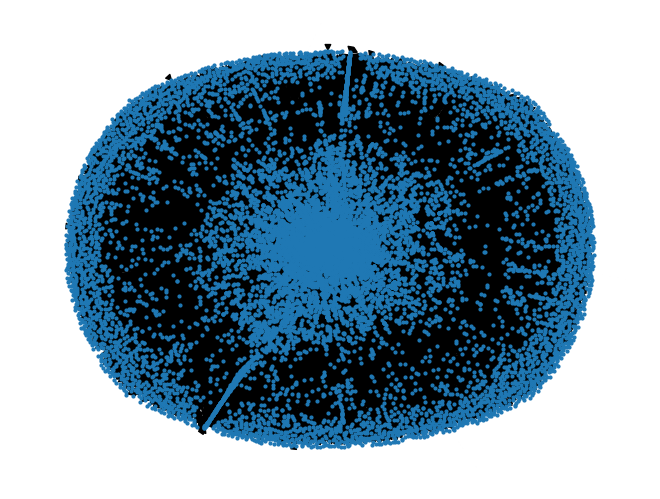

In [9]:
# Read data from output.csv
df = pd.read_csv('output.csv')

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for index, row in df.iterrows():
    G.add_edge(row['source_subreddit'], row['target_subreddit'])

# Define layout for better visualization
pos = nx.spring_layout(G)

# Plot the graph with arrows
nx.draw(G, pos, with_labels=False, font_weight='bold', arrows=True, font_size=6,node_size=4)

# Show the plot
plt.show()

# Original Vs Predicted

In [13]:
from collections import defaultdict

# Create a defaultdict to store the edge counts for each pair of subreddits
edge_counts = defaultdict(int)

# Read data from the CSV file
with open('data-orig.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        source_subreddit = row['source_subreddit']
        target_subreddit = row['target_subreddit']
        timestamp = row['timestamp']
        # Check if '2017' is present anywhere in the timestamp
        if '2017' in timestamp:
            # Form a pair of source and target subreddits
            edge_pair = (source_subreddit, target_subreddit)

            # Increment the count for the pair
            edge_counts[edge_pair] += 1

# Prepare data for output.csv
output_data = [(source, target, count) for (source, target), count in edge_counts.items()]

# Write to analysis.csv
with open('analysis.csv', 'w', newline='') as output_file:
    csv_writer = csv.writer(output_file)
    csv_writer.writerow(['source_subreddit', 'target_subreddit', 'number_of_edges'])
    csv_writer.writerows(output_data)

# Accuracy of the predictive model

In [14]:
analysis_data = []
with open('analysis.csv', 'r') as analysis_file:
    csv_reader = csv.DictReader(analysis_file)
    for row in csv_reader:
        analysis_data.append(int(row['number_of_edges']))

# Load data from output.csv
output_data = []
with open('output.csv', 'r') as output_file:
    csv_reader = csv.DictReader(output_file)
    for row in csv_reader:
        output_data.append(int(row['Expected Edges']))

# Calculate the sum of absolute differences and the average
sum_diff = 0
total_rows = min(len(analysis_data), len(output_data))

for i in range(total_rows):
    sum_diff += abs(analysis_data[i] - output_data[i])

average_diff = sum_diff / total_rows if total_rows > 0 else 0

print(f'accuracy (in percentage): {(100-(average_diff*100))}')


accuracy (in percentage): 37.1967654986523
